## Baseline Models

- Logistic Regression 
- LightGBM


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier
import joblib
import mlflow
import mlflow.sklearn
mlflow.lightgbm.autolog(disable=True)
import json
import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


In [2]:
df = pd.read_csv('../../data/raw/application_train.csv')

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df['TARGET'].value_counts(normalize=True)}")


Dataset shape: (307511, 122)
Target distribution: TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


### Feature Selection

Select features with low missing rates and good predictive potential.

Due to explainability and regulatory concerns, including variables such as religion, gender, or education in the model can cause issues when explaining to a user why their application was rejected.

Although these variables may improve model performance during development, the business side might not approve their use in production. Therefore, such variables can be excluded from the final model.

`'CNT_CHILDREN', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',`


In [3]:
numerical_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'REGION_POPULATION_RELATIVE', 'DAYS_LAST_PHONE_CHANGE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

categorical_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE'
]

features = numerical_features + categorical_features
X = df[features].copy()
y = df['TARGET'].copy()

print(f"Selected features: {len(features)}")
print(f"Numerical: {len(numerical_features)}, Categorical: {len(categorical_features)}")


Selected features: 36
Numerical: 25, Categorical: 11


In [4]:
missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
print("\nTop 10 features by missing %:")
print(missing_pct.head(10))



Top 10 features by missing %:
EXT_SOURCE_1                  56.381073
OCCUPATION_TYPE               31.345545
EXT_SOURCE_3                  19.825307
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_HOUR    13.501631
DEF_60_CNT_SOCIAL_CIRCLE       0.332021
dtype: float64


### Train/Validation Split


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"\nTrain target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nVal target distribution:\n{y_val.value_counts(normalize=True)}")


Train size: 246008 (80.0%)
Val size: 61503 (20.0%)

Train target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Val target distribution:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


### Baseline 1: Logistic Regression


In [6]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_log = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

log_pipeline = Pipeline([
    ('preprocessor', preprocessor_log),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='lbfgs'
    ))
])

print("Logistic Regression pipeline created")


Logistic Regression pipeline created


In [7]:
%%time

log_pipeline.fit(X_train, y_train)

print("Training complete")


Training complete
CPU times: total: 2min 6s
Wall time: 17 s


In [8]:
y_train_pred_proba_log = log_pipeline.predict_proba(X_train)[:, 1]
y_val_pred_proba_log = log_pipeline.predict_proba(X_val)[:, 1]
y_val_pred_log = log_pipeline.predict(X_val)

train_auc_log = roc_auc_score(y_train, y_train_pred_proba_log)
val_auc_log = roc_auc_score(y_val, y_val_pred_proba_log)
precision_log = precision_score(y_val, y_val_pred_log)
recall_log = recall_score(y_val, y_val_pred_log)
f1_log = f1_score(y_val, y_val_pred_log)

print("Logistic Regression Results:")
print(f"Train ROC-AUC: {train_auc_log:.4f}")
print(f"Val ROC-AUC: {val_auc_log:.4f}")
print(f"Val Precision: {precision_log:.4f}")
print(f"Val Recall: {recall_log:.4f}")
print(f"Val F1-Score: {f1_log:.4f}")


Logistic Regression Results:
Train ROC-AUC: 0.7449
Val ROC-AUC: 0.7455
Val Precision: 0.1604
Val Recall: 0.6755
Val F1-Score: 0.2593


In [9]:
cm_log = confusion_matrix(y_val, y_val_pred_log)
print("Confusion Matrix (Validation):")
print(cm_log)

Confusion Matrix (Validation):
[[38984 17554]
 [ 1611  3354]]


In [10]:
feature_names_log = (numerical_features + 
                     log_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features).tolist())

coefficients = log_pipeline.named_steps['classifier'].coef_[0]
feature_importance_log = pd.DataFrame({
    'feature': feature_names_log,
    'coefficient': np.abs(coefficients)
}).sort_values('coefficient', ascending=False)

print("\nTop 20 Important Features (Logistic Regression):")
print(feature_importance_log.head(20))



Top 20 Important Features (Logistic Regression):
                                               feature  coefficient
37                          NAME_INCOME_TYPE_Pensioner     5.718252
141                              ORGANIZATION_TYPE_XNA     5.108279
5                                        DAYS_EMPLOYED     4.916831
42                 NAME_EDUCATION_TYPE_Academic degree     2.202240
41                            NAME_INCOME_TYPE_Working     2.034894
38                      NAME_INCOME_TYPE_State servant     1.951324
35               NAME_INCOME_TYPE_Commercial associate     1.936467
133                    ORGANIZATION_TYPE_Trade: type 5     1.069978
132                    ORGANIZATION_TYPE_Trade: type 4     1.061709
3                                      AMT_GOODS_PRICE     0.938618
120                          ORGANIZATION_TYPE_Realtor     0.903918
1                                           AMT_CREDIT     0.857476
45                 NAME_EDUCATION_TYPE_Lower secondary     0.74617

### Baseline 2: LightGBM


In [11]:
X_train_lgb = X_train.copy()
X_val_lgb = X_val.copy()

cat_mappings = {}
for col in categorical_features:
    unique_vals = X_train_lgb[col].dropna().unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    cat_mappings[col] = mapping
    X_train_lgb[col] = X_train_lgb[col].map(mapping)
    X_val_lgb[col] = X_val_lgb[col].map(mapping)

print(f"Categorical mappings created for {len(cat_mappings)} features")


Categorical mappings created for 11 features


In [12]:
%%time

lgb_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    class_weight='balanced',
    verbose=-1
)

lgb_model.fit(
    X_train_lgb, y_train,
    eval_set=[(X_val_lgb, y_val)],
    eval_metric='auc'
)
print("Training complete")

Training complete
CPU times: total: 36.8 s
Wall time: 6.97 s


In [13]:
y_train_pred_proba_lgb = lgb_model.predict_proba(X_train_lgb)[:, 1]
y_val_pred_proba_lgb = lgb_model.predict_proba(X_val_lgb)[:, 1]
y_val_pred_lgb = lgb_model.predict(X_val_lgb)

train_auc_lgb = roc_auc_score(y_train, y_train_pred_proba_lgb)
val_auc_lgb = roc_auc_score(y_val, y_val_pred_proba_lgb)
precision_lgb = precision_score(y_val, y_val_pred_lgb)
recall_lgb = recall_score(y_val, y_val_pred_lgb)
f1_lgb = f1_score(y_val, y_val_pred_lgb)

print("LightGBM Results:")
print(f"Train ROC-AUC: {train_auc_lgb:.4f}")
print(f"Val ROC-AUC: {val_auc_lgb:.4f}")
print(f"Val Precision: {precision_lgb:.4f}")
print(f"Val Recall: {recall_lgb:.4f}")
print(f"Val F1-Score: {f1_lgb:.4f}")


LightGBM Results:
Train ROC-AUC: 0.8288
Val ROC-AUC: 0.7610
Val Precision: 0.1746
Val Recall: 0.6588
Val F1-Score: 0.2760


In [14]:
cm_lgb = confusion_matrix(y_val, y_val_pred_lgb)
print("Confusion Matrix (Validation):")
print(cm_lgb)

Confusion Matrix (Validation):
[[41073 15465]
 [ 1694  3271]]


In [15]:
feature_importance_lgb = pd.DataFrame({
    'feature': features,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Important Features (LightGBM):")
print(feature_importance_lgb.head(20))



Top 20 Important Features (LightGBM):
                       feature  importance
14                EXT_SOURCE_3        1345
12                EXT_SOURCE_1        1206
13                EXT_SOURCE_2        1093
4                   DAYS_BIRTH         995
2                  AMT_ANNUITY         893
1                   AMT_CREDIT         882
11      DAYS_LAST_PHONE_CHANGE         809
7              DAYS_ID_PUBLISH         794
5                DAYS_EMPLOYED         779
6            DAYS_REGISTRATION         769
3              AMT_GOODS_PRICE         710
10  REGION_POPULATION_RELATIVE         662
0             AMT_INCOME_TOTAL         607
35           ORGANIZATION_TYPE         429
33             OCCUPATION_TYPE         396
24  AMT_REQ_CREDIT_BUREAU_YEAR         303
30         NAME_EDUCATION_TYPE         229
34  WEEKDAY_APPR_PROCESS_START         202
15    OBS_30_CNT_SOCIAL_CIRCLE         190
23   AMT_REQ_CREDIT_BUREAU_QRT         173


### Model Comparison


In [16]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM'],
    'Train AUC': [train_auc_log, train_auc_lgb],
    'Val AUC': [val_auc_log, val_auc_lgb],
    'Precision': [precision_log, precision_lgb],
    'Recall': [recall_log, recall_lgb],
    'F1-Score': [f1_log, f1_lgb]
})

print("\nModel Comparison:")
print(results.to_string(index=False))



Model Comparison:
              Model  Train AUC  Val AUC  Precision   Recall  F1-Score
Logistic Regression   0.744923 0.745538   0.160417 0.675529  0.259266
           LightGBM   0.828766 0.761014   0.174584 0.658812  0.276022


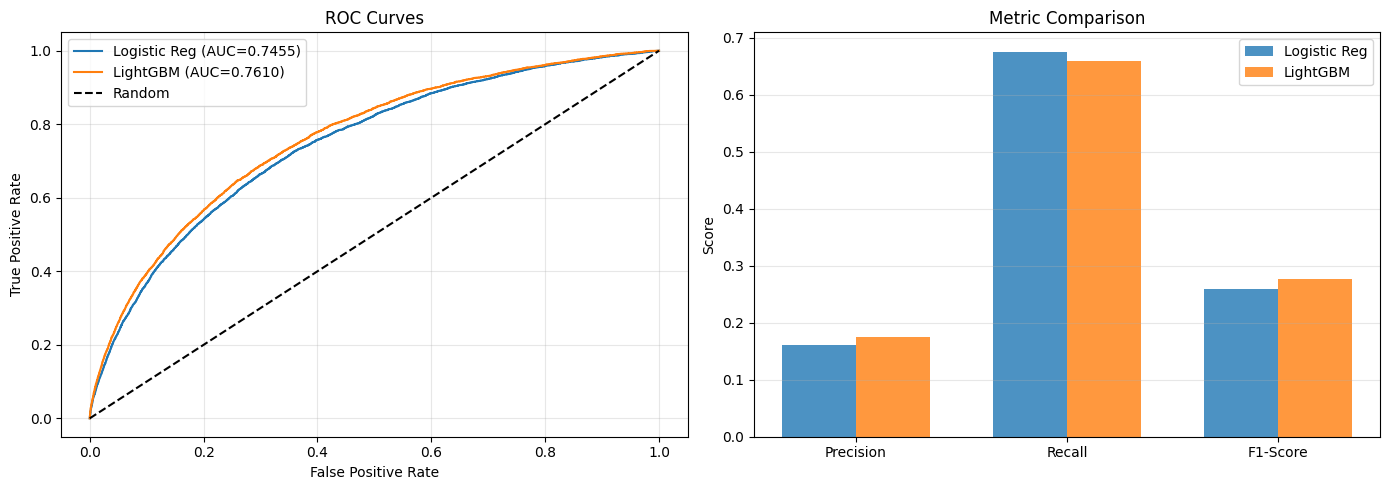

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fpr_log, tpr_log, _ = roc_curve(y_val, y_val_pred_proba_log)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, y_val_pred_proba_lgb)

axes[0].plot(fpr_log, tpr_log, label=f'Logistic Reg (AUC={val_auc_log:.4f})')
axes[0].plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC={val_auc_lgb:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

metrics = ['Precision', 'Recall', 'F1-Score']
log_scores = [precision_log, recall_log, f1_log]
lgb_scores = [precision_lgb, recall_lgb, f1_lgb]

x = np.arange(len(metrics))
width = 0.35
axes[1].bar(x - width/2, log_scores, width, label='Logistic Reg', alpha=0.8)
axes[1].bar(x + width/2, lgb_scores, width, label='LightGBM', alpha=0.8)
axes[1].set_ylabel('Score')
axes[1].set_title('Metric Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


### Save Models


In [18]:
joblib.dump(log_pipeline, '../../models/baseline_logistic_v1.pkl')
print("Saved: models/baseline_logistic_v1.pkl")

lgb_artifacts = {
    'model': lgb_model,
    'cat_mappings': cat_mappings,
    'features': features,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features
}
joblib.dump(lgb_artifacts, '../../models/baseline_lightgbm_v1.pkl')
print("Saved: models/baseline_lightgbm_v1.pkl")


Saved: models/baseline_logistic_v1.pkl
Saved: models/baseline_lightgbm_v1.pkl


### MLflow Tracking


In [19]:
mlflow_tracking_uri = os.path.join(os.getcwd(), 'mlruns')
mlflow.set_tracking_uri(f"file:///{mlflow_tracking_uri}")

mlflow.set_experiment("baseline_models")

with mlflow.start_run(run_name="logistic_regression_v1"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("n_features", len(features))
    
    mlflow.log_metric("train_auc", train_auc_log)
    mlflow.log_metric("val_auc", val_auc_log)
    mlflow.log_metric("val_precision", precision_log)
    mlflow.log_metric("val_recall", recall_log)
    mlflow.log_metric("val_f1", f1_log)
    
    mlflow.sklearn.log_model(log_pipeline, "model")
    
    feature_config = {
        'all_features': features,
        'numerical_features': numerical_features,
        'categorical_features': categorical_features
    }
    with open('features_log.json', 'w') as f:
        json.dump(feature_config, f, indent=2)
    mlflow.log_artifact('features_log.json')
    
    cm_data = {
        'confusion_matrix': cm_log.tolist(),
        'labels': ['No Default', 'Default']
    }
    with open('confusion_matrix_log.json', 'w') as f:
        json.dump(cm_data, f, indent=2)
    mlflow.log_artifact('confusion_matrix_log.json')

print("Logged Logistic Regression to MLflow")

with mlflow.start_run(run_name="lightgbm_v1"):
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("n_estimators", 500)
    mlflow.log_param("learning_rate", 0.05)
    mlflow.log_param("max_depth", 7)
    mlflow.log_param("n_features", len(features))
    
    mlflow.log_metric("train_auc", train_auc_lgb)
    mlflow.log_metric("val_auc", val_auc_lgb)
    mlflow.log_metric("val_precision", precision_lgb)
    mlflow.log_metric("val_recall", recall_lgb)
    mlflow.log_metric("val_f1", f1_lgb)
    
    mlflow.sklearn.log_model(lgb_model, "model")
    
    with open('features_lgb.json', 'w') as f:
        json.dump(feature_config, f, indent=2)
    mlflow.log_artifact('features_lgb.json')
    
    joblib.dump(cat_mappings, 'cat_mappings.pkl')
    mlflow.log_artifact('cat_mappings.pkl')
    
    cm_data = {
        'confusion_matrix': cm_lgb.tolist(),
        'labels': ['No Default', 'Default']
    }
    with open('confusion_matrix_lgb.json', 'w') as f:
        json.dump(cm_data, f, indent=2)
    mlflow.log_artifact('confusion_matrix_lgb.json')
    
    feature_importance_lgb.to_csv('feature_importance_lgb.csv', index=False)
    mlflow.log_artifact('feature_importance_lgb.csv')

print("Logged LightGBM to MLflow")

# Cleanup temporary files
for f in ['features_log.json', 'features_lgb.json', 'cat_mappings.pkl', 
          'confusion_matrix_log.json', 'confusion_matrix_lgb.json', 
          'feature_importance_lgb.csv']:
    if os.path.exists(f):
        os.remove(f)

2025/11/12 15:11:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/12 15:11:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/12 15:11:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/12 15:12:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged Logistic Regression to MLflow


2025/11/12 15:12:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/12 15:12:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged LightGBM to MLflow


### Generate Kaggle Submissions


In [20]:
test_df = pd.read_csv('../../data/raw/application_test.csv')
sample_submission = pd.read_csv('../../data/raw/sample_submission.csv')

print(f"Test dataset shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"\nSample submission format:")
print(sample_submission.head())


Test dataset shape: (48744, 121)
Sample submission shape: (48744, 2)

Sample submission format:
   SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5


In [21]:
X_test = test_df[features].copy()

print("Generating predictions for Logistic Regression...")
test_pred_proba_log = log_pipeline.predict_proba(X_test)[:, 1]

submission_log = pd.DataFrame({
    'SK_ID_CURR': test_df['SK_ID_CURR'],
    'TARGET': test_pred_proba_log
})

print(f"Logistic Regression submission shape: {submission_log.shape}")
print(f"Prediction range: [{test_pred_proba_log.min():.4f}, {test_pred_proba_log.max():.4f}]")
print(f"Mean prediction: {test_pred_proba_log.mean():.4f}")


Generating predictions for Logistic Regression...
Logistic Regression submission shape: (48744, 2)
Prediction range: [0.0086, 0.9995]
Mean prediction: 0.4331


In [ ]:
X_test_lgb = X_test.copy()

for col in categorical_features:
    X_test_lgb[col] = X_test_lgb[col].map(cat_mappings[col])

print("Generating predictions for LightGBM...")
test_pred_proba_lgb = lgb_model.predict_proba(X_test_lgb)[:, 1]

submission_lgb = pd.DataFrame({
    'SK_ID_CURR': test_df['SK_ID_CURR'],
    'TARGET': test_pred_proba_lgb
})

print(f"LightGBM submission shape: {submission_lgb.shape}")
print(f"Prediction range: [{test_pred_proba_lgb.min():.4f}, {test_pred_proba_lgb.max():.4f}]")
print(f"Mean prediction: {test_pred_proba_lgb.mean():.4f}")


Generating predictions for LightGBM...
LightGBM submission shape: (48744, 2)
Prediction range: [0.0039, 0.9659]
Mean prediction: 0.3894


In [ ]:
os.makedirs('../../data/submissions', exist_ok=True)

submission_log.to_csv('../../data/submissions/baseline_logistic_v1.csv', index=False)
print("Saved: data/submissions/baseline_logistic_v1.csv")

submission_lgb.to_csv('../../data/submissions/baseline_lightgbm_v1.csv', index=False)
print("Saved: data/submissions/baseline_lightgbm_v1.csv")


Saved: data/submissions/baseline_logistic_v1.csv
Saved: data/submissions/baseline_lightgbm_v1.csv
